In [2]:
!pip install matplotlib

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1/100, Reward: -1048.3669376550129
Episode 2/100, Reward: -1343.3306518297795
Episode 3/100, Reward: -1160.2488335189175
Episode 4/100, Reward: -1507.175654891339
Episode 5/100, Reward: -1036.8306533392583
Episode 6/100, Reward: -1138.0634670644283
Episode 7/100, Reward: -1206.3441554588012
Episode 8/100, Reward: -1353.1944117647204
Episode 9/100, Reward: -975.5782815087537
Episode 10/100, Reward: -1214.1223114112454
Episode 11/100, Reward: -1020.9107874079015
Episode 12/100, Reward: -1100.2705673877383
Episode 13/100, Reward: -1133.728699606494
Episode 14/100, Reward: -1558.9989532095908
Episode 15/100, Reward: -1374.4679826851593
Episode 16/100, Reward: -1097.4696293108605
Episode 17/100, Reward: -993.5604402759169
Episode 18/100, Reward: -1522.391841782678
Episode 19/100, Reward: -1550.301532025429
Episode 20/100, Reward: -1177.3827358176904
Episode 21/100, Reward: -1213.747822143426
Episode 22/100, Reward: -1370.478646881026
Episode 23/100, Reward: -1245.0399087195108
Episo

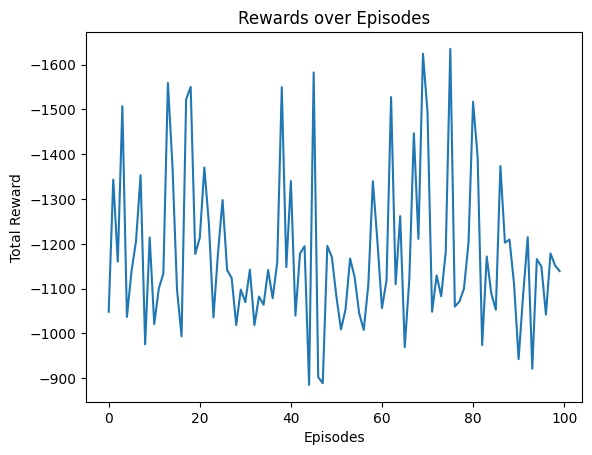

In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions
import matplotlib.pyplot as plt

class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.Tanh(),
            nn.Linear(64, action_size),
            nn.Tanh()
        )
        self.critic = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        action_mean = self.actor(x)
        state_value = self.critic(x)
        return action_mean, state_value

class PPOAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99, eps_clip=0.2):
        self.policy = ActorCritic(state_size, action_size)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        self.eps_clip = eps_clip

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        action_mean, _ = self.policy(state)
        cov_mat = torch.diag(torch.ones(action_size))  # Assuming diagonal covariance matrix
        dist = torch.distributions.MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        return action.detach().numpy(), dist.log_prob(action)

    def update(self, states, actions, log_probs, returns, advantages):
        action_means, values = self.policy(states)

        cov_mat = torch.diag(torch.ones(action_size))  # Assuming diagonal covariance matrix
        dists = torch.distributions.MultivariateNormal(action_means, cov_mat)
        new_log_probs = dists.log_prob(actions)

        ratio = (new_log_probs - log_probs).exp()
        surrogate1 = ratio * advantages
        surrogate2 = torch.clamp(ratio, 1.0 - self.eps_clip, 1.0 + self.eps_clip) * advantages

        actor_loss = -torch.min(surrogate1, surrogate2).mean()
        critic_loss = nn.functional.mse_loss(values.flatten(), returns)

        loss = actor_loss + 0.5 * critic_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, env, max_episodes=100, max_steps=1000):
        episode_rewards = []
        for episode in range(1, max_episodes + 1):
            state = env.reset()
            episode_reward = 0
            states, actions, log_probs, rewards, values = [], [], [], [], []
            for step in range(max_steps):
                action, log_prob = self.select_action(state)
                next_state, reward, done, _ = env.step(action)

                states.append(torch.tensor(state, dtype=torch.float32))
                actions.append(torch.tensor(action, dtype=torch.float32))
                rewards.append(reward)
                policy, value = self.policy(torch.tensor(state, dtype=torch.float32))
                values.append(value)
                log_probs.append(log_prob)

                state = next_state
                episode_reward += reward

                if done or step == max_steps - 1:
                    next_value = torch.tensor([0.0]) if done else self.policy(torch.tensor(state, dtype=torch.float32))[1]
                    returns = []
                    advantages = []
                    discounted_sum = 0
                    for reward, value in zip(reversed(rewards), reversed(values)):
                        returns.append(discounted_sum)
                        advantages.append(discounted_sum - value.item())
                        discounted_sum = reward + self.gamma * discounted_sum
                    returns.reverse()
                    advantages.reverse()
                    states = torch.stack(states)
                    actions = torch.stack(actions)
                    log_probs = torch.stack(log_probs)
                    returns = torch.tensor(returns, dtype=torch.float32)
                    advantages = torch.tensor(advantages, dtype=torch.float32)
                    self.update(states, actions, log_probs, returns, advantages)
                    episode_rewards.append(episode_reward)
                    print(f"Episode {episode}/{max_episodes}, Reward: {episode_reward}")
                    break

        env.close()
        return episode_rewards

# Main script to train PPO agent on Pendulum-v1 environment
if __name__ == "__main__":
    env = gym.make('Pendulum-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]  # Assuming continuous actions

    agent = PPOAgent(state_size, action_size)

    episode_rewards = agent.train(env, max_episodes=100)

    # Plotting rewards over episodes
    plt.plot(episode_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Rewards over Episodes')
    plt.gca().invert_yaxis()
    plt.show()


# Initialize policy network with random weights
policy = PolicyNetwork()

# Initialize value function network with random weights
value_function = ValueFunctionNetwork()

# Initialize optimizer for policy and value function
policy_optimizer = AdamOptimizer(policy.parameters, lr=learning_rate_policy)
value_optimizer = AdamOptimizer(value_function.parameters, lr=learning_rate_value)

# Main training loop
for epoch in range(num_epochs):
    # Initialize batch storage
    batch_states = []
    batch_actions = []
    batch_advantages = []
    batch_returns = []
    
    # Collect trajectories
    for _ in range(num_trajectories):
        state = env.reset()
        trajectory_states = []
        trajectory_actions = []
        trajectory_rewards = []
        
        # Collect one full trajectory
        while not done:
            # Select action using current policy
            action = policy.select_action(state)
            
            # Execute action in the environment
            next_state, reward, done, _ = env.step(action)
            
            # Store state, action, reward
            trajectory_states.append(state)
            trajectory_actions.append(action)
            trajectory_rewards.append(reward)
            
            # Move to next state
            state = next_state
        
        # Calculate advantages and returns
        returns = calculate_returns(trajectory_rewards)
        advantages = calculate_advantages(trajectory_rewards, value_function)
        
        # Append trajectory data to batch storage
        batch_states.extend(trajectory_states)
        batch_actions.extend(trajectory_actions)
        batch_advantages.extend(advantages)
        batch_returns.extend(returns)
    
    # Optimize policy and value function networks
    optimize_policy(policy, policy_optimizer, batch_states, batch_actions, batch_advantages)
    optimize_value_function(value_function, value_optimizer, batch_states, batch_returns)
    
    # Print epoch statistics
    print(f"Epoch {epoch}: Average Return = {np.mean(batch_returns)}")
